In [1]:
data='https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [2]:
!wget $data

--2025-10-16 17:40:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.08s   

2025-10-16 17:40:26 (1.01 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [156]:
import numpy as np
import pandas as pd

In [157]:
df=pd.read_csv("course_lead_scoring.csv")

In [158]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [159]:
df.dtypes


lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [160]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [161]:
categorical=['lead_source','industry','employment_status','location']     
numerical=['annual_income']

In [162]:
df[categorical]=df[categorical].fillna('NA')

In [163]:
df[numerical]=df[numerical].fillna(0.0)

In [164]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [165]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [167]:
df_full_train,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [168]:
numerical=['lead_score',
'number_of_courses_viewed',
'interaction_count',
'annual_income']

In [169]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [170]:
for c in numerical:
    score=roc_auc_score(y_train,np.array(df_train[c]))
    print(score)   

0.6144993577250176
0.7635680590007088
0.738270176293409
0.5519578313253012


In [171]:
X_train_num = df_train[numerical].values

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)

dv=DictVectorizer(sparse=False)
train_dict=df_train[categorical].to_dict(orient='records')
X_train_cat=dv.fit_transform(train_dict)

X_train = np.column_stack([X_train_num, X_train_cat])

model=LogisticRegression(solver='liblinear', C=1, max_iter=1000)
model.fit(X_train,y_train)

X_val_num = df_val[numerical].values
X_val_num = scaler.transform(X_val_num)


val_dict=df_val[categorical].to_dict(orient='records')
X_val_cat=dv.transform(val_dict)

X_val = np.column_stack([X_val_num, X_val_cat])

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val,y_pred)

0.920956763493433

In [172]:
from sklearn.metrics import precision_score,recall_score

In [173]:
scores = []

thresholds = np.arange(0.0, 0.98, 0.01)
y_pred = model.predict_proba(X_val)[:, 1]

for t in thresholds:
    y_decision = (y_pred >= t).astype(int)

    precision = precision_score(y_val, y_decision)
    recall = recall_score(y_val, y_decision)
    f1=2*precision*recall/(precision+recall)

    scores.append((t, precision, recall,f1))

scored_df = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall','f1score'])

In [174]:
scored_df

,threshold,precision,recall,f1score
0,0.00,0.583618,1.000000,0.737069
1,0.01,0.595819,1.000000,0.746725
2,0.02,0.608541,1.000000,0.756637
3,0.03,0.611511,0.994152,0.757238
4,0.04,0.622711,0.994152,0.765766
...,...,...,...,...
93,0.93,0.955056,0.497076,0.653846
94,0.94,0.954545,0.491228,0.648649
95,0.95,0.950000,0.444444,0.605578
96,0.96,0.985075,0.385965,0.554622


In [175]:
import matplotlib.pyplot as plt

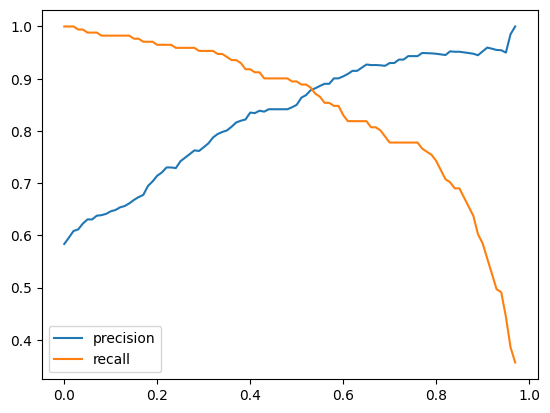

In [176]:
plt.plot(scored_df.threshold,scored_df.precision,label='precision')
plt.plot(scored_df.threshold,scored_df.recall,label='recall')
plt.legend()

In [177]:
intersection_threshold = thresholds[np.argmin(np.abs(scored_df.precision - scored_df.recall))]

In [178]:
intersection_threshold

np.float64(0.53)

In [179]:
scored_df[scored_df.threshold==0.55]

,threshold,precision,recall,f1score
55,0.55,0.886228,0.865497,0.87574


In [180]:
scored_df.f1score.max()

np.float64(0.880466472303207)

In [193]:
def train(df_train, y_train, C=1.0):
    X_train_num = df_train[numerical].values
    
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    
    dv=DictVectorizer(sparse=False)
    train_dict=df_train[categorical].to_dict(orient='records')
    X_train_cat=dv.fit_transform(train_dict)
    
    X_train = np.column_stack([X_train_num, X_train_cat])
    
    model=LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train,y_train)
    
    return dv, model

In [194]:
def predict(df, dv, model):
    X_val_num = df_val[numerical].values
    X_val_num = scaler.transform(X_val_num)
    
    val_dict=df_val[categorical].to_dict(orient='records')
    X_val_cat=dv.transform(val_dict)
    
    X_val = np.column_stack([X_val_num, X_val_cat])
    
    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

In [195]:
from sklearn.model_selection import KFold

In [196]:
kfold=KFold(n_splits=5, shuffle=True, random_state=1)

scores=[]
for train_idx,val_idx in kfold.split(df_full_train):
    df_train=df_full_train.iloc[train_idx]
    df_val=df_full_train.iloc[val_idx]
    
    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.921 +- 0.010


In [199]:
for C in [0.000001,0.001,1]:
    kfold=KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores=[]
    for train_idx,val_idx in kfold.split(df_full_train):
        df_train=df_full_train.iloc[train_idx]
        df_val=df_full_train.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv, model = train(df_train, y_train,C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.903 +- 0.013
C=0.001 0.905 +- 0.013
C=1 0.921 +- 0.010
